In [1]:
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import warnings
from passive_splitter_combiner_tree import PassiveSplitterCombinerTree
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")

In [2]:
num_sweep = 20001
random_variable_sigma = [0.04]
dc_variability = ["common", "differential"]

rand_dc = {}
num_dc = 12

rand_dc_splitratio = {}

for idd_sigma, sigma in enumerate(random_variable_sigma):
    rand_dc_splitratio[sigma] = {}
    for idd_dc in range(num_dc):
      rand_dc_splitratio[sigma].update({idd_dc: np.clip((1+np.random.normal(0, sigma, num_sweep)) * 0.5, 0,1)})

In [3]:
loss_median = 0.09
loss_3sigma = 0.03

rand_dc_loss = {}
for idd_sigma, sigma in enumerate(random_variable_sigma):
    rand_dc_loss[sigma] = {}
    for idd_dc in range(num_dc):
      rand_dc_loss[sigma].update({'idd_dc': np.random.normal(0, loss_3sigma/3, num_sweep) + loss_median})

SiN_directional_coupler_loss_dB_list = [
  0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12
]

SiN_crossing_loss_dB_list = [
  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01
]

SiN_crossing_crosstalk_dB_list = [
  -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0
]

psct_tmatrix = np.zeros((len(dc_variability), len(random_variable_sigma), num_sweep, 8, 8))
psct_dc_splitratio = np.zeros((len(dc_variability), len(random_variable_sigma), num_sweep, num_dc))


for idd_dc_mode, dc_var_mode in enumerate(dc_variability):
    for idd_sigma, sigma in enumerate(random_variable_sigma):
        for idd_num_sweep in tqdm(range(num_sweep)):
            SiN_directional_coupler_splitratio_list = []
            if dc_var_mode == "common":
                for idd_dc in range(num_dc):
                  SiN_directional_coupler_splitratio_list.append(
                      rand_dc_splitratio[sigma][0][idd_num_sweep]
                  )
                  psct_dc_splitratio[idd_dc_mode][idd_sigma][idd_num_sweep][idd_dc] = rand_dc_splitratio[sigma][0][idd_num_sweep]
            elif dc_var_mode == "differential":
                for idd_dc in range(num_dc):
                  SiN_directional_coupler_splitratio_list.append(
                      rand_dc_splitratio[sigma][idd_dc][idd_num_sweep]
                  )      
                  psct_dc_splitratio[idd_dc_mode][idd_sigma][idd_num_sweep][idd_dc] = rand_dc_splitratio[sigma][idd_dc][idd_num_sweep]
            
            SiN_directional_coupler_loss_dB_list = np.ones(num_dc) * rand_dc_loss[sigma]['idd_dc'][idd_num_sweep]

            PSCT = PassiveSplitterCombinerTree(
              SiN_directional_coupler_loss_dB_list=SiN_directional_coupler_loss_dB_list,
              SiN_directional_coupler_splitratio_list=SiN_directional_coupler_splitratio_list,
              SiN_crossing_loss_dB_list=SiN_crossing_loss_dB_list,
              SiN_crossing_crosstalk_dB_list=SiN_crossing_crosstalk_dB_list
            )
            for idd_row in range(8):
               for idd_col in range(8):
                  psct_tmatrix[idd_dc_mode][idd_sigma][idd_num_sweep][idd_row][idd_col] = np.real(PSCT.tmatrix[idd_row][idd_col]*np.conj(PSCT.tmatrix[idd_row][idd_col]))

100%|██████████| 20001/20001 [12:24:49<00:00,  2.23s/it]    


In [4]:
psct_dataset = xr.Dataset(
  data_vars = dict(
    tmatrix = (["dc_variability", "random_variable_sigma", "num_sweep", "row", "col"], psct_tmatrix),
    dc_splitratio = (["dc_variability", "random_variable_sigma", "num_sweep", "dc_channel"], psct_dc_splitratio)
  ),
  coords = dict(
    dc_variability = dc_variability,
    random_variable_sigma = random_variable_sigma,
    num_sweep = np.arange(num_sweep),
    row = np.arange(8),
    col = np.arange(8),
    dc_channel = np.arange(num_dc),
    SiN_crossing_loss_dB_list = SiN_crossing_loss_dB_list,
    SiN_crossing_crosstalk_dB_list = SiN_crossing_crosstalk_dB_list,
    SiN_directional_coupler_loss_dB_list = SiN_directional_coupler_loss_dB_list
  ),
  attrs = dict(description="Monte-Carlo simulations of Passive Splitter Combiner Tree")
)

In [5]:
psct_dataset.to_netcdf("psct_dataset.nc")

In [6]:
psct_dataset

<xarray.Dataset>
Dimensions:                               (dc_variability: 2,
                                           random_variable_sigma: 1,
                                           num_sweep: 20001, row: 8, col: 8,
                                           dc_channel: 12,
                                           SiN_crossing_loss_dB_list: 8,
                                           SiN_crossing_crosstalk_dB_list: 8,
                                           SiN_directional_coupler_loss_dB_list: 12)
Coordinates:
  * dc_variability                        (dc_variability) <U12 'common' 'dif...
  * random_variable_sigma                 (random_variable_sigma) float64 0.04
  * num_sweep                             (num_sweep) int64 0 1 ... 19999 20000
  * row                                   (row) int64 0 1 2 3 4 5 6 7
  * col                                   (col) int64 0 1 2 3 4 5 6 7
  * dc_channel                            (dc_channel) int64 0 1 2 3 ... 9 10 11
  * SiN_crossing_loss_dB_list             (SiN_crossing_loss_dB_list) float64 ...
  * SiN_crossing_crosstalk_dB_list        (SiN_crossing_crosstalk_dB_list) float64 ...
  * SiN_directional_coupler_loss_dB_list  (SiN_directional_coupler_loss_dB_list) float64 ...
Data variables:
    tmatrix                               (dc_variability, random_variable_sigma, num_sweep, row, col) float64 ...
    dc_splitratio                         (dc_variability, random_variable_sigma, num_sweep, dc_channel) float64 ...
Attributes:
    description:  Monte-Carlo simulations of Passive Splitter Combiner Tree

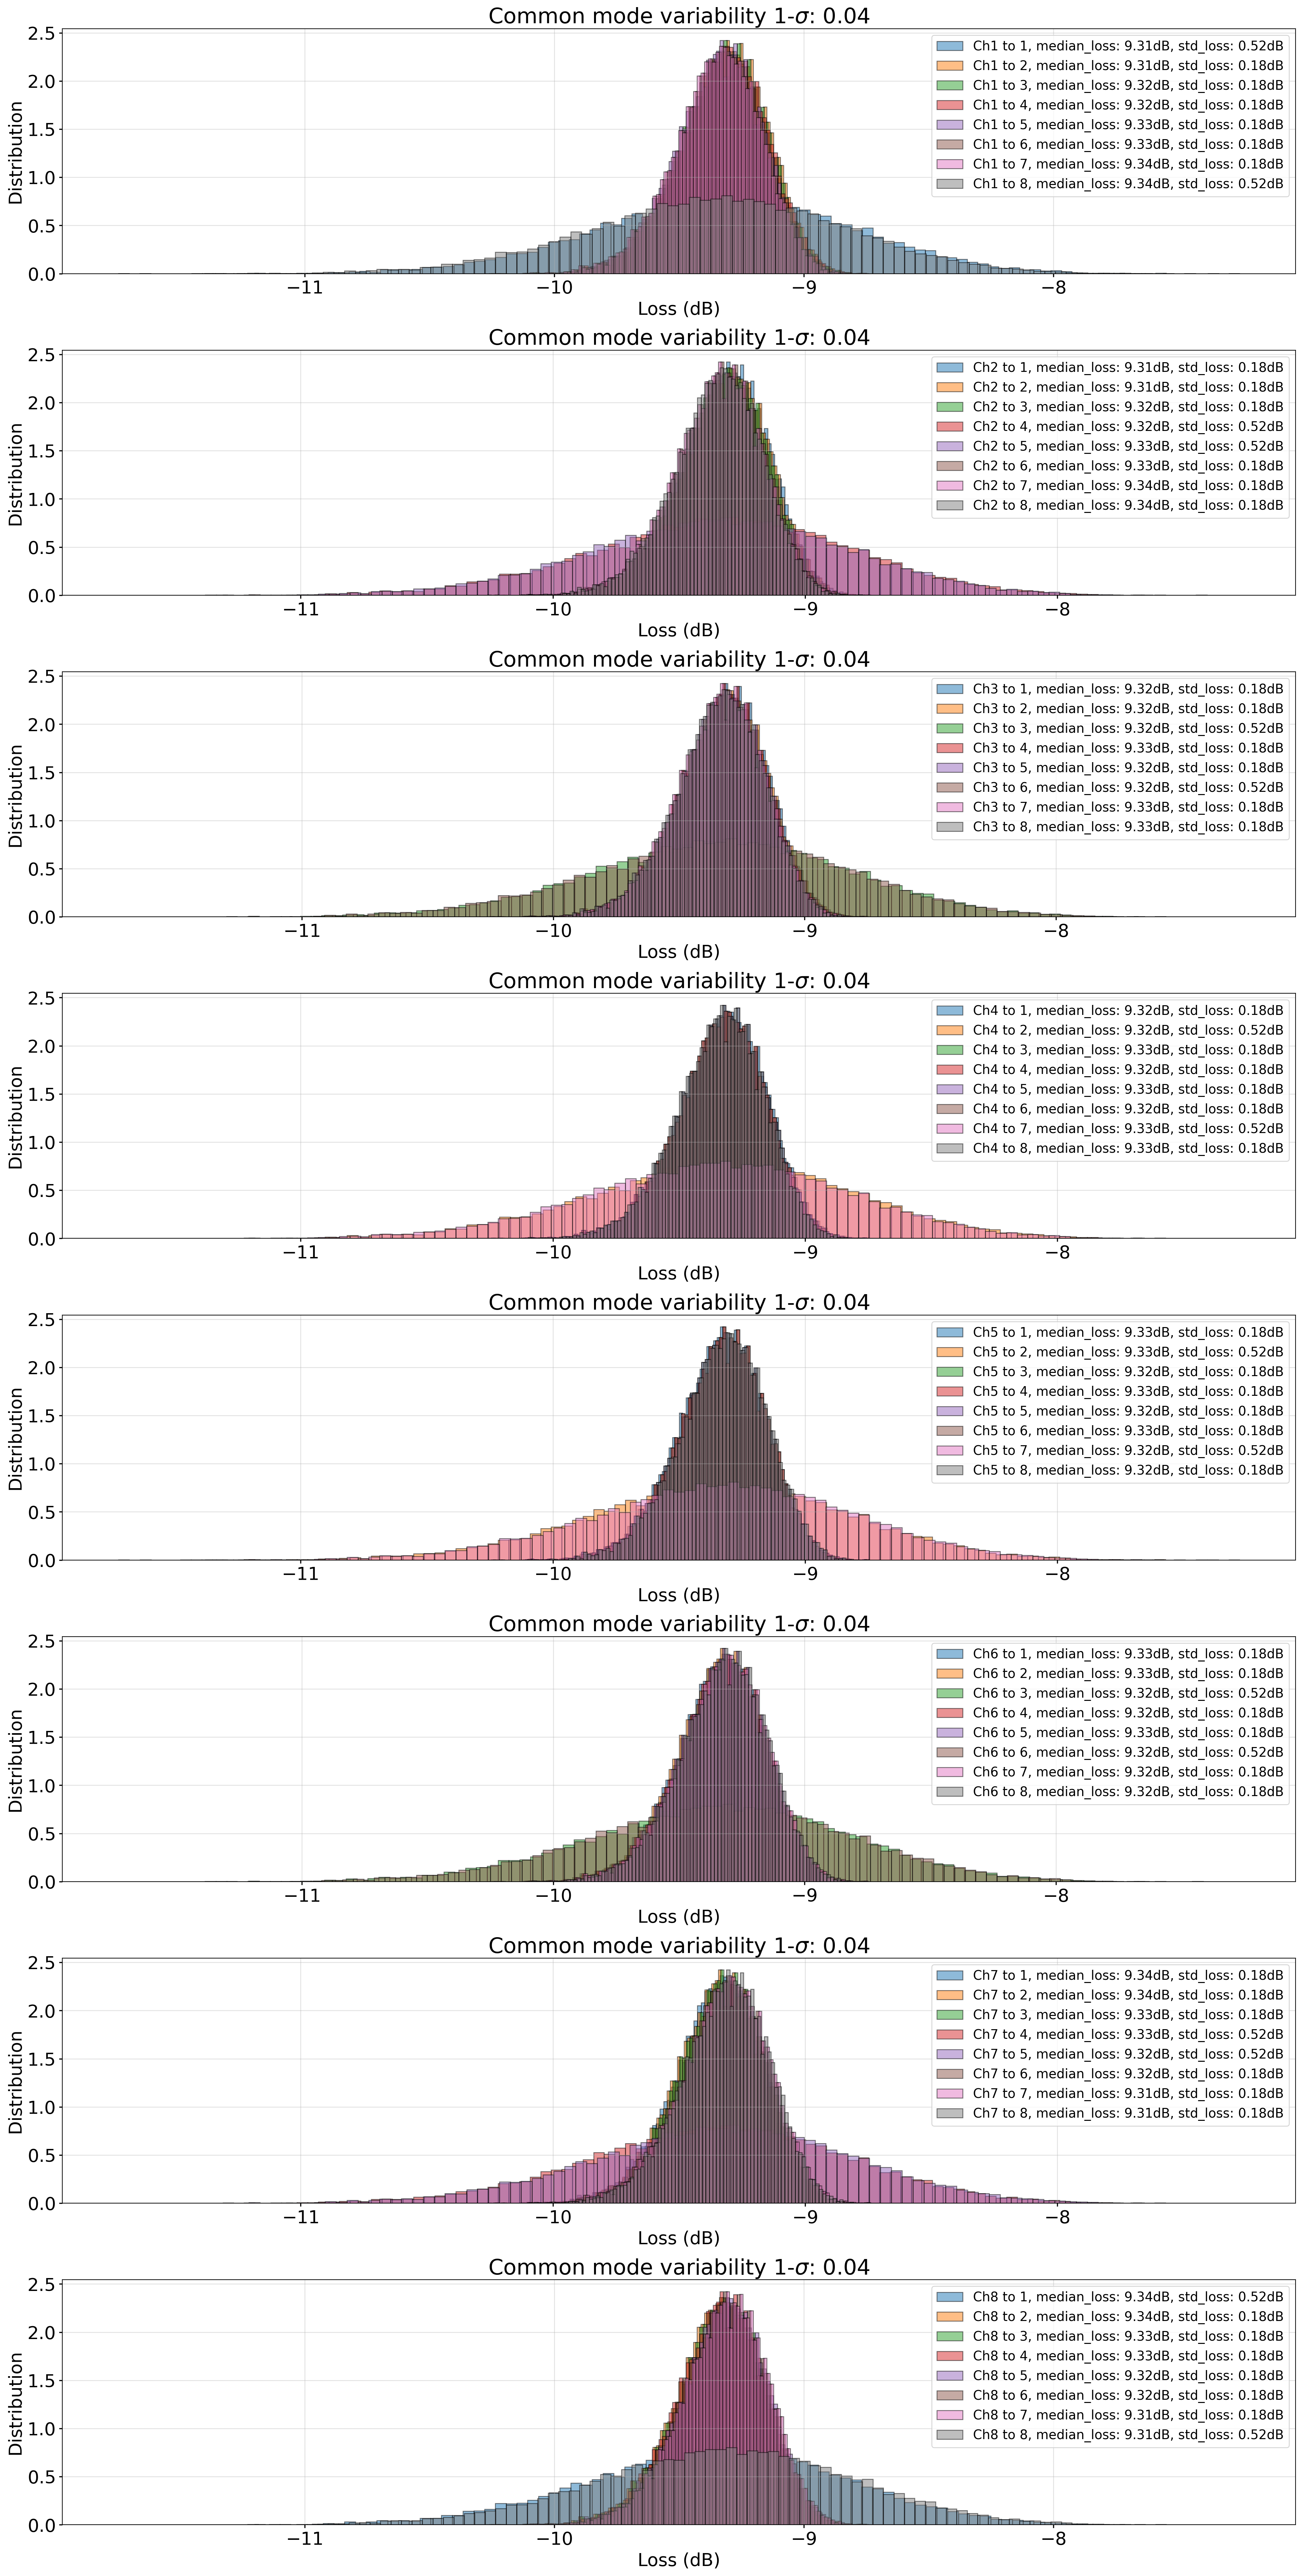

In [8]:
tmatrix_common = psct_dataset.tmatrix.sel(dc_variability="common")
plt.figure(figsize=(20,40))
for idd_dc_sigma, dc_sigma in enumerate(tmatrix_common.random_variable_sigma.values):    
    for idd_row, row in enumerate(psct_dataset["row"].values):
        plt.subplot(len(psct_dataset["row"].values), len(tmatrix_common.random_variable_sigma.values), idd_dc_sigma + 1 + idd_row*len(tmatrix_common.random_variable_sigma.values))
        for idd_col, col in enumerate(psct_dataset["col"].values):
            plt.hist(10*np.log10(tmatrix_common.sel(random_variable_sigma=dc_sigma, row=row, col=col).values), density=True, bins=100, alpha=0.5, edgecolor="black", label="Ch" + str(row+1)+" to "+str(col+1)+f", median_loss: {-1*np.median(10*np.log10(tmatrix_common.sel(random_variable_sigma=dc_sigma, row=row, col=col).values)):0.2f}dB, std_loss: {np.std(10*np.log10(tmatrix_common.sel(random_variable_sigma=dc_sigma, row=row, col=col).values)):0.2f}dB")
        plt.legend()
        plt.title(r"Common mode variability 1-$\sigma$: " + str(dc_sigma))
        plt.xlabel("Loss (dB)")
        plt.ylabel("Distribution")
plt.tight_layout()

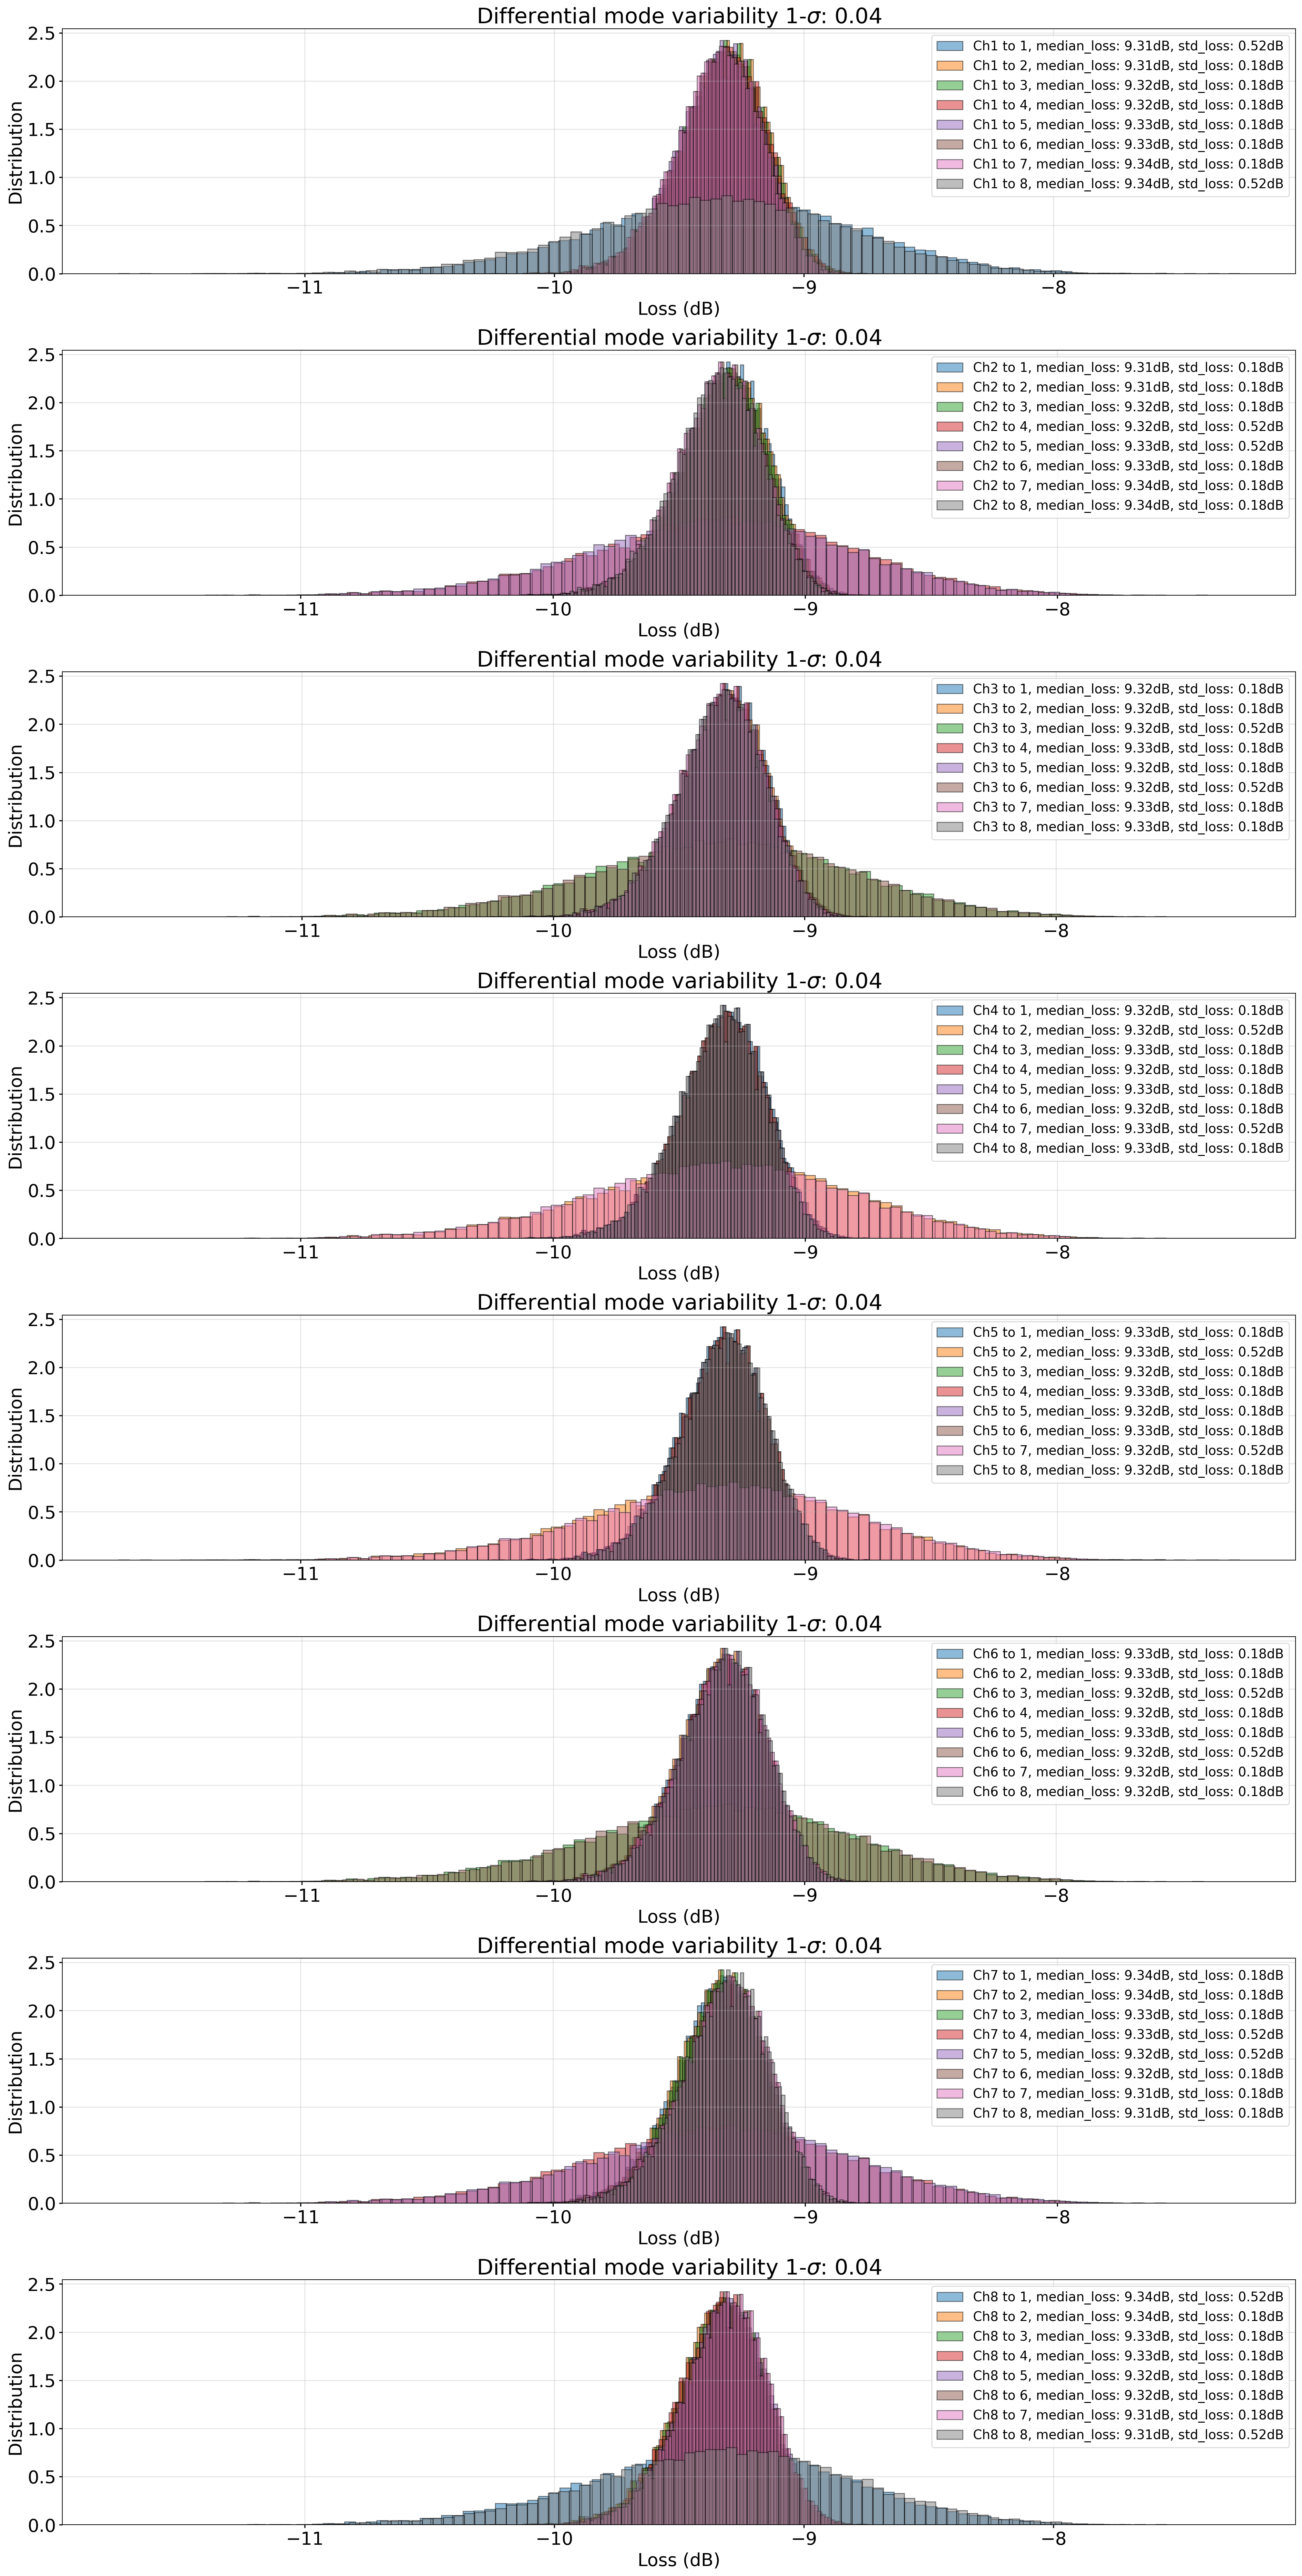

In [9]:
tmatrix_differential = psct_dataset.tmatrix.sel(dc_variability="differential")
plt.figure(figsize=(20,40))
for idd_dc_sigma, dc_sigma in enumerate(tmatrix_differential.random_variable_sigma.values):
    for idd_row, row in enumerate(psct_dataset["row"].values):
        plt.subplot(len(tmatrix_differential.row.values), len(tmatrix_differential.random_variable_sigma.values), idd_dc_sigma+1 + idd_row*len(tmatrix_differential.random_variable_sigma.values))
        for idd_col, col in enumerate(psct_dataset["col"].values):
            plt.hist(10*np.log10(tmatrix_common.sel(random_variable_sigma=dc_sigma, row=row, col=col).values), density=True, bins=100, alpha=0.5, edgecolor="black", label="Ch" + str(row+1)+" to "+str(col+1)+f", median_loss: {-1*np.median(10*np.log10(tmatrix_common.sel(random_variable_sigma=dc_sigma, row=row, col=col).values)):0.2f}dB, std_loss: {np.std(10*np.log10(tmatrix_common.sel(random_variable_sigma=dc_sigma, row=row, col=col).values)):0.2f}dB")
        plt.title(r"Differential mode variability 1-$\sigma$: " + str(dc_sigma))
        plt.xlabel("Loss (dB)")
        plt.ylabel("Distribution")
        plt.legend()
plt.tight_layout()